In [40]:
import folium
import pandas as pd
import numpy as np
import os
import json
import itertools
import matplotlib.pyplot as plt
from branca.colormap import linear
%matplotlib inline

In [125]:
# This cell is copied from https://gist.github.com/llimllib/4974446

import json
from pprint import pprint as pp

def jenks_matrices_init(data, n_classes):
    #fill the matrices with data+1 arrays of n_classes 0s
    lower_class_limits = []
    variance_combinations = []
    for i in range(0, len(data)+1):
        temp1 = []
        temp2 = []
        for j in range(0, n_classes+1):
            temp1.append(0.)
            temp2.append(0.)
        lower_class_limits.append(temp1)
        variance_combinations.append(temp2)

    inf = float('inf')
    for i in range(1, n_classes+1):
        lower_class_limits[1][i] = 1.
        variance_combinations[1][i] = 0.
        for j in range(2, len(data)+1):
            variance_combinations[j][i] = inf

    return lower_class_limits, variance_combinations

def jenks_matrices(data, n_classes):
    lower_class_limits, variance_combinations = jenks_matrices_init(data, n_classes)

    variance = 0.0
    for l in range(2, len(data)+1):
        sum = 0.0
        sum_squares = 0.0
        w = 0.0
        for m in range(1, l+1):
            # `III` originally
            lower_class_limit = l - m + 1
            val = data[lower_class_limit-1]

            # here we're estimating variance for each potential classing
            # of the data, for each potential number of classes. `w`
            # is the number of data points considered so far.
            w += 1

            # increase the current sum and sum-of-squares
            sum += val
            sum_squares += val * val

            # the variance at this point in the sequence is the difference
            # between the sum of squares and the total x 2, over the number
            # of samples.
            variance = sum_squares - (sum * sum) / w

            i4 = lower_class_limit - 1

            if i4 != 0:
                for j in range(2, n_classes+1):
                    if variance_combinations[l][j] >= (variance + variance_combinations[i4][j - 1]):
                        lower_class_limits[l][j] = lower_class_limit
                        variance_combinations[l][j] = variance + variance_combinations[i4][j - 1]

        lower_class_limits[l][1] = 1.
        variance_combinations[l][1] = variance

    return lower_class_limits, variance_combinations

def get_jenks_breaks(data, lower_class_limits, n_classes):
    k = len(data) - 1
    kclass = [0.] * (n_classes+1)
    countNum = n_classes

    kclass[n_classes] = data[len(data) - 1]
    kclass[0] = data[0]

    while countNum > 1:
        elt = int(lower_class_limits[k][countNum] - 2)
        kclass[countNum - 1] = data[elt]
        k = int(lower_class_limits[k][countNum] - 1)
        countNum -= 1

    return kclass

def jenks(data, n_classes):
    if n_classes > len(data): return

    data.sort()

    lower_class_limits, _ = jenks_matrices(data, n_classes)

    return get_jenks_breaks(data, lower_class_limits, n_classes)

# Part 1

In [126]:
europe_data_path =  os.path.join('data', 'lfsa_urgaed_1_Data.csv')
europe_data_original = pd.DataFrame.from_csv(europe_data_path, sep=',')


europe_data = europe_data_original.copy()

europe_data['GEO'] = europe_data['GEO'].astype('str').replace('Germany.+','Germany', regex=True)
europe_data['GEO'] = europe_data['GEO'].astype('str').replace('.+Yugoslav.+','The former Yugoslav Republic of Macedonia', regex=True)

europe_data.index = europe_data['GEO']
europe_data = europe_data[['GEO','Value']]

europe_data.head()

,GEO,Value
GEO,,
Belgium,Belgium,7.7
Bulgaria,Bulgaria,7.6
Czech Republic,Czech Republic,3.9
Denmark,Denmark,5.7
Germany,Germany,4.1


# Notes:
- order of layers are important for visual rendering
- at first we merged on the country code key, but there were unmerged data because eurostat uses english country codes while the provided topojson uses french country code (yet english country full names). We then found that it is possible to download the data from eurostat in a better way: with english country names, and no footnotes (which avoids removing them in python)
- To verify our map we can compare with the one on the eurostat page (http://ec.europa.eu/eurostat/tgm/mapToolClosed.do?tab=map&init=1&plugin=1&language=en&pcode=tepsr_wc170&toolbox=types#), and other maps on internet
- TODO: plot with color scale instead of 4 colors
- TODO implement Jenks classification
- TODO show number of members in each class!

In [198]:
n_colors = 6
jenks_class = jenks(europe_data['Value'].values, n_colors)
print(jenks_class)

def find_index_first_greater_than(x, jenks_class):
    return next(itertools.chain(iter(i for i,v in enumerate(jenks_class) if v > x), [len(jenks_class)-1]))

d = europe_data['Value'].values
nnn = 24
ind = find_index_first_greater_than(nnn,jenks_class)
print(ind)

[2.7999999999999998, 5.0, 6.7999999999999998, 9.8000000000000007, 12.9, 19.300000000000001, 23.5]
6


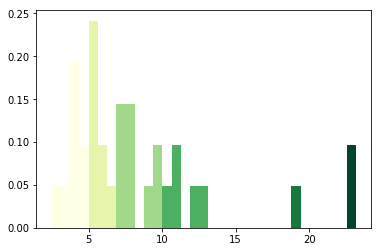

In [244]:
colormap_europe = plt.get_cmap('YlGn', n_colors)

Y,X = np.histogram(d, len(d), normed=1) # TODO no sens that second arg is len(d)
C = [colormap_europe(find_index_first_greater_than(x, jenks_class)-1) for x in X]
plt.bar(X[:-1], Y, color=C, width=X[1]-X[0])
plt.show()

#TODO show 1 bar per datapoint if possible

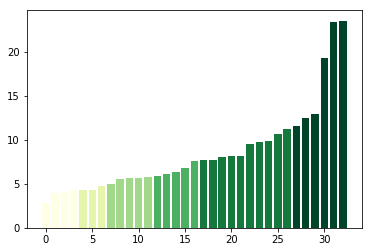

In [245]:
plt.bar(range(len(d)), d, color=C)
plt.show()

In [248]:
europe_topojson_path = os.path.join('topojson', 'europe.topojson.json')

europe_topojson = json.load(open(europe_topojson_path))
europe_map = folium.Map(
    location=[53.5775, 23.106111],
    tiles='Mapbox Bright',
    zoom_start=4
)

# to be sure, sort by values first
aaaa = pd.Series(C)
europe_data['color'] = aaaa

europe_unemp_dict = europe_data.set_index("GEO")["Value"]

'''
color_dict_europe = {}
for index, key in enumerate(europe_unemp_dict):
    print(europe_unemp_dict[key])
    color_dict_europe[europe_unemp_dict[key]] = C[index]
'''

europe_color_dict = {key: colormap_europe(europe_unemp_dict[key]) for key in europe_unemp_dict.keys()}



europe_style_function = lambda x: {'fillColor': europe_color_dict[x['properties']['NAME']],
                            'fillOpacity': 0.9,
                           }

europe_map.choropleth(geo_data=europe_topojson, data=europe_data,
                   name='choropleth',
                   columns=['GEO','Value'],
                   key_on='feature.properties.NAME',
                   fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
                   topojson='objects.europe',
                   legend_name='Unemployment rate (%)')


# This layer lets us display countries that have missing data
folium.TopoJson(
    europe_topojson,
    'objects.europe',
    style_function=europe_style_function
).add_to(europe_map)


#folium.LayerControl().add_to(europe_map)

europe_map

KeyError: 'Azerbaijan'

# Part 2

Getting the Switzerland unemployement data from the provided website was a bit tricky. We first had to specify the encoding to utf-16. And also manually edit the csv file to remove the "month" and "total" element which appears to be a second layer of header which we don't need. We also rename the canton to match the json file. Il could be automaticly done with a maping, or with adding a new column with canton id.

In [239]:

#Set the path and load the Json data.
swiss_topojson_path = os.path.join('topojson', 'ch-cantons.topojson.json')

#Load the map with a correct zoom on Switzerland.
swiss_map = folium.Map(location = [46.8, 8.227], tiles='Mapbox Bright', zoom_start = 8)

#Load the Switzerland unemployement's data.
swiss_unemployement_Sept2017 = os.path.join('data', 'swiss_unemployement_2.csv')
swiss_unemployement = pd.read_csv(swiss_unemployement_Sept2017, sep=';', encoding="utf-16")
swiss_unemployement = swiss_unemployement.drop('Mesures', 1).drop('Taux de chômage.1', 1).drop('Chômeurs inscrits.1', 1).drop("Demandeurs d'emploi.1", 1).drop("Demandeurs d'emploi non chômeurs.1", 1)

#Create a dictionnary in order to map a "canton" to its unemployement rate .
swiss_unemp_dict = swiss_unemployement.set_index("Canton")["Taux de chômage"]

#Create a colormap
colormap = linear.YlGn.scale(0, swiss_unemployement["Taux de chômage"].max())

#Create a dictionnary of color based on our "canton" - unemployement rate dictionnary.
color_dict = {key: colormap(swiss_unemp_dict[key]) for key in swiss_unemp_dict.keys()}

#The color function to apply on our "canton".
style_function = lambda x: {'fillColor': color_dict[x['properties']['name']],
                            'fillOpacity': 0.9,
                           }

folium.TopoJson(open(swiss_topojson_path, encoding="utf-8"),
                'objects.cantons',
                name='topojson',
                style_function=style_function
               ).add_to(swiss_map)

colormap.caption = 'Unemployment color scale in percent [%]'
colormap.add_to(swiss_map)

#save the map as an html element to show it on GitHub.
swiss_map.save(os.path.join('results', 'GeoJSON_SwissMap_1.html'))

swiss_map

Canton
Zürich                    3.3
Bern/Berne                2.4
Luzern                    1.7
Uri                       0.6
Schwyz                    1.7
Obwalden                  0.7
Nidwalden                 1.0
Glarus                    1.8
Zug                       2.3
Fribourg                  2.7
Solothurn                 2.6
Basel-Stadt               3.5
Basel-Landschaft          2.8
Schaffhausen              3.0
Appenzell Ausserrhoden    1.7
Appenzell Innerrhoden     0.7
St. Gallen                2.2
Graubünden/Grigioni       1.1
Aargau                    2.9
Thurgau                   2.0
Ticino                    3.1
Vaud                      4.3
Valais/Wallis             2.8
Neuchâtel                 5.1
Genève                    5.2
Jura                      4.4
Total                     3.0
Name: Taux de chômage, dtype: float64